## Description
Author: shuheng.mo21@imperial.ac.uk (sm321@ic.ac.uk)          

This notebook contains the parallelisation of 2D Advection-diffusion equation implemented with MPI (mpi4py). The script within this notebook is converted to Python scripts and presented at [here](https://github.com/ese-msc-2021/irp-sm321/tree/main/code).          


## Prerequisites

Datatypes map between mpi4py and the numpy:(reference: https://groups.google.com/g/mpi4py/c/u33WWWKThDs)        
```
typemap = {
        np.dtype(np.float64) : MPI.DOUBLE,
        np.dtype(np.float32) : MPI.FLOAT,
        np.dtype(np.int)     : MPI.INT,
        np.dtype(np.int8)    : MPI.CHAR,
        np.dtype(np.uint8)   : MPI.UNSIGNED_CHAR,
        np.dtype(np.int32)   : MPI.INT,
        np.dtype(np.uint32)  : MPI.UNSIGNED_INT,
    }
```

Note: we can pass numpy datatypes into Tensorflow tensor.  
Please remember to install the required dependencies below.

In [80]:
## Install the required dependencies
# ! python -m pip install mpi4py
! mkdir output
! mkdir norms
! mkdir serial_steps
! mkdir parallel_steps

mkdir: output: File exists
mkdir: norms: File exists
mkdir: serial_steps: File exists
mkdir: parallel_steps: File exists


## Problem Details
Boyang et al. have implemented the [CFD model](https://www.imperial.ac.uk/people/c.heaney/document/9723/AI_for_CFD_v1b/?AI_for_CFD_v1b.pdf) for solving 2D advection-diffusion equation with TensorFlow. This notebook cited their implementation and was legally approved. The problem was formulated as below:                

$\frac{\partial T}{\partial t} + u\frac{\partial T}{\partial x}+ v\frac{\partial T}{\partial y}+ \sigma T- \nu \nabla^2T = s $.               

in which T is a scalar concentration field with size 300m by 300m,$t$ is time, ($u,v$) are the advection velocities.$\sigma$,$\nu$ and $s$ respectively are the absorption term, constant diffusivity and source term. Boundary conditions fixed zero solutions at the edges of the domain (No-flux boundary condition). Note for the equation formulated in this work, $\sigma = s = 0$ and advection velocity is fixed with ($1ms^{-1},1ms^{-1}$). So the expected pattern for those two initialised distributions are to be advected to the upper-right corner while diffused with constant coefficient.

alternatively the problem can be formulated as:

$\frac{\partial T}{\partial t} + u\frac{\partial T}{\partial x}+ v\frac{\partial T}{\partial y} = \nu \nabla^2T $. 


## Serial Code

In [205]:
%%writefile advection_diffusion_2D.py
## imports
import sys
assert sys.version_info >= (3,5)

import math

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os
import time
from mpi4py import MPI

################################ Load data and initial conditions #######################
# Load data and set initial condition
nx, ny = 300, 300
T = np.zeros([nx, ny], dtype=np.float64)
gamma = 40
# initialise t:
x0 = 0
y0 = -50
x = np.zeros([1, nx], dtype=np.float64)
y = np.zeros([1, ny], dtype=np.float64)

for ii in range(nx):
    x[0][ii] = -150 + 300/nx*ii
    y[0][ii] = -150 + 300/nx*ii

# boundary excluded: range 1-299 x 1-299, I suppose we are using Dirichlet boundary condition
for i in range(1, 299):
    for j in range(1, 299):
        temp1 = -((x[0][i] - x0)**2 + (y[0][j] - y0)**2)
        temp2 = 2*gamma**2
        T[i][j] = math.exp(temp1/temp2)

input_shape = (1, nx, ny, 1)  # (1,300,300,1) as original problem size

mesh = np.zeros(input_shape, dtype=np.float64) # default data type of np.zeros is np.float64

# generate Gaussian with a blob
for i in range(nx):
    for j in range(ny):
        mesh[0][i][j][0] = T[i][j]  # + Z1[i][j] + Z2[i][j] + Z3[i][j]*0.5

# generate Gaussian with a blob
for i in range(50):
    for j in range(50):
        mesh[0][i+225][j+125][0] = mesh[0][i+225][j+125][0] + 1

values = np.copy(mesh)

# values is just a copy of mesh

################################ Initializations ####################################
start_time = time.perf_counter()

# weight matrices
w1 = ([[[[0.0],        # upwind
        [0.2],
        [0.0]],

        [[0.3],
        [-1.0],
        [0.2]],

        [[0.0],
        [0.3],
        [0.0]]]])

w2 = ([[[[0.0],        # central
        [0.15],
        [0.0]],

        [[0.25],
        [-0.8],
        [0.15]],

        [[0.0],
        [0.25],
        [0.0]]]])

# print(np.array(w1).shape) # shape (1,3,3,1)
init_kernel_1 = w1
init_kernel_2 = w2

init_bias = np.zeros((1,))  # filters - need change to exact value for bias

kernel_initializer_1 = tf.keras.initializers.constant(
    init_kernel_1)  # initializer which initialize constant tensor
kernel_initializer_2 = tf.keras.initializers.constant(init_kernel_2)

bias_initializer = tf.keras.initializers.constant(init_bias)

# CNN 2D layers: now I generate CNN filters for each subdomains
# filter 1
CNN2D_1 = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=(nx, ny, 1)),
    tf.keras.layers.Conv2D(1, kernel_size=3, strides=1, padding='SAME',
                          #                                activation='relu',
                          kernel_initializer=kernel_initializer_1,
                          bias_initializer=bias_initializer),
    #         tf.keras.layers.Conv2D(1, kernel_size=3, strides=1, padding='SAME',
    #                                activation='relu',
    #                                kernel_initializer=kernel_initializer_2,
    #                                bias_initializer=bias_initializer),
])

# filter 2
CNN2D_2 = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=(nx, ny, 1)),
    tf.keras.layers.Conv2D(1, kernel_size=3, strides=1, padding='SAME',
                          #                                activation='relu',
                          kernel_initializer=kernel_initializer_2,
                          bias_initializer=bias_initializer),
    #         tf.keras.layers.Conv2D(1, kernel_size=3, strides=1, padding='SAME',
    #                                activation='relu',
    #                                kernel_initializer=kernel_initializer_2,
    #                                bias_initializer=bias_initializer),
])

# here set up the hyperparameters to tune in the later training process
CNN2D_1.compile(loss="mse",
                optimizer=keras.optimizers.Nadam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999))
CNN2D_2.compile(loss="mse",
              optimizer=keras.optimizers.Nadam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999))

# store the l1,l2,linf norms
l1_norms = np.array([])
l2_norms = np.array([])
linf_norms = np.array([])

# running for 1000 steps
for t in range(2):
    # one-step
    # a = CNN2D_2.predict(values)
    # values += a

    # two-step scheme with central scheme
    a = CNN2D_2.predict(values)
    np.save('serial_steps/a_{}'.format(t),a)
    b = (a + values)
    np.save('serial_steps/b_{}'.format(t),b)
    c = (b + values)*0.5
    np.save('serial_steps/c_{}'.format(t),c)
    d = CNN2D_2.predict(c)
    np.save('serial_steps/d_{}'.format(t),d)
    values += d
    
    np.save('serial_steps/AD_2D_step_{}'.format(t),values)
    

    # if t %10 == 0: # save the l1 norm and l2 norm of result per 10 timesteps
    #l1_norms = np.append(l1_norms, np.linalg.norm(values.reshape(300,300), ord=1)/90000)
    #l2_norms = np.append(l2_norms, np.linalg.norm(values.reshape(300,300), ord=2)/90000)
    #linf_norms = np.append(linf_norms, np.linalg.norm(values.reshape(300,300), ord=np.inf)/90000)
    #np.save("/content/serial_steps/AD_2D_serial_step_{}".format(t),values.reshape(nx, ny))


end_time = time.perf_counter()
print(f"[INFO] Problem solved in {end_time - start_time:0.4f} seconds using serial solution.")

# save the final result to text file
np.save("output/AD_2D_serial", values.reshape(nx,ny))
# np.save("/content/norms/AD_2D_serial_l1_norms", l1_norms)
# np.save("/content/norms/AD_2D_serial_l2_norms", l2_norms)
# np.save("/content/norms/AD_2D_serial_linf_norms", linf_norms)

Overwriting advection_diffusion_2D.py


In [206]:
# run the serial code
! python advection_diffusion_2D.py 

2022-11-17 23:58:59.351947: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
1/1 [==============================] - 0s 15ms/step
[INFO] Problem solved in 0.2299 seconds using serial solution.


## MPI subroutines
All functions for communicating halos (2D, and perhaps 3D) has been encapsulated in Python subroutine named as **halo_exchange.py**. It will be called to parallelize the corresponding code.

**Note that this subroutine is going to be improved:
```
from ... import HaloExchange
h = HaloExchange()
h.initialization()
```

## Parallelisation example

In [211]:
%%writefile parallel_advection_diffusion_2D.py
from mpi4py import MPI
import halo_exchange
import os
import numpy as np  # cupy can be used as optimisation if CUDA/AMD GPUs are available
from tensorflow import keras
import tensorflow as tf
import math
import sys
assert sys.version_info >= (3, 5)
assert tf.__version__ >= "2.0"
np.set_printoptions(threshold=sys.maxsize)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # avoid dnn issue

################################ Load data and initial conditions #######################
# Load data and set initial condition
nx, ny = 300, 300
T = np.zeros([nx, ny], dtype=np.float64)
gamma = 40
# initialise t:
x0 = 0
y0 = -50
x = np.zeros([1, nx],dtype=np.float64)
y = np.zeros([1, ny],dtype=np.float64)

for ii in range(nx):
    x[0][ii] = -150 + 300/nx*ii
    y[0][ii] = -150 + 300/nx*ii

# boundary excluded: range 1-299 x 1-299, I suppose we are using Dirichlet boundary condition
for i in range(1, 299):
    for j in range(1, 299):
        temp1 = -((x[0][i] - x0)**2 + (y[0][j] - y0)**2)
        temp2 = 2*gamma**2
        T[i][j] = math.exp(temp1/temp2)

input_shape = (1, nx, ny, 1)  # (1,300,300,1) as original problem size
values = np.zeros(input_shape,dtype=np.float64) # initalization of the mesh

# generate Gaussian distribution with a blob
for i in range(nx):
    for j in range(ny):
      values[0][i][j][0] = T[i][j]  # + Z1[i][j] + Z2[i][j] + Z3[i][j]*0.5

# generate Gaussian with a blob
for i in range(50):
    for j in range(50):
        values[0][i+225][j+125][0] = values[0][i+225][j+125][0] + 1

################################ MPI Implementation ####################################
start_time = MPI.Wtime() # start timer

# dt = 0.1, dx = 1.0, dy = 1.0, (u,v) = (1, 1)
sub_nx,sub_ny, current_domain = halo_exchange.domain_decomposition_2D(values,nx,ny)
rank = halo_exchange.rank
num_process = halo_exchange.num_process

print(type(current_domain))

# 5 stencils
# schemes for advection-term
w1 = ([[[[0.0],        # upwind
        [0.2],
        [0.0]],

        [[0.3],
        [-1.0],
        [0.2]],

        [[0.0],
        [0.3],
        [0.0]]]])

w2 = ([[[[0.0],        # central
        [0.15],
        [0.0]],

        [[0.25],
        [-0.8],
        [0.15]],

        [[0.0],
        [0.25],
        [0.0]]]])


init_kernel_1 = w1
init_kernel_2 = w2

init_bias = np.zeros((1,))  # filters - need change to exact value for bias

kernel_initializer_1 = tf.keras.initializers.constant(
    init_kernel_1)  # initializer which initialize constant tensor
kernel_initializer_2 = tf.keras.initializers.constant(init_kernel_2)

bias_initializer = tf.keras.initializers.constant(init_bias)

# CNN 2D layers: now I generate CNN filters for each subdomains
# filter 1
CNN2D_1 = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=(sub_nx+2, sub_ny+2, 1)),
    tf.keras.layers.Conv2D(1, kernel_size=3, strides=1, padding='SAME',
                          kernel_initializer=kernel_initializer_1,
                          bias_initializer=bias_initializer),
])

# filter 2
CNN2D_2 = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=(sub_nx+2, sub_ny+2, 1)),
    tf.keras.layers.Conv2D(1, kernel_size=3, strides=1, padding='SAME',
                          kernel_initializer=kernel_initializer_2,
                          bias_initializer=bias_initializer),
])

# here set up the hyperparameters to tune in the later training process
CNN2D_1.compile(loss="mse",
                optimizer=keras.optimizers.Nadam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999))
CNN2D_2.compile(loss="mse",
                optimizer=keras.optimizers.Nadam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999))

# place_holder for final result
result = np.empty((1,))

# do the first update to get the halo values
current_domain = halo_exchange.structured_halo_update_2D(current_domain)



for t in range(2):
    # print('CURRENT_DOMAIN_SHAPE: ',current_domain.shape)
    # current_domain = tf.convert_to_tensor(current_domain.reshape(1,sub_nx+2,sub_ny+2,1))
    print('CURRENT_DOMAIN_SHAPE: ',current_domain.shape)
    
    # one-step method
    # a = CNN2D_2.predict(net_input)
    # net_input[0,1:-1,1:-1,0] += a.reshape(sub_nx+2,sub_ny+2)

    # predictor-corrector scheme
    a = CNN2D_2.predict(current_domain)
    np.save('parallel_steps/a_proc_{}_step_{}'.format(rank,t),a)
    b = (a + current_domain)
    np.save('parallel_steps/b_proc_{}_step_{}'.format(rank,t),b)
    c = (b + current_domain)*0.5
    c = halo_exchange.structured_halo_update_2D(c) # do one halo update
    np.save('parallel_steps/c_proc_{}_step_{}'.format(rank,t),c)
    d = CNN2D_2.predict(c)
    np.save('parallel_steps/d_proc_{}_step_{}'.format(rank,t),d)
    current_domain += d
    current_domain = tf.identity(halo_exchange.structured_halo_update_2D(current_domain))
                                 
    np.save('parallel_steps/AD_2D_proc_{}_parallel_2_step_{}'.format(rank,t),current_domain)

    result = current_domain.numpy().reshape(sub_nx+2, sub_ny+2) # assign the values to the placeholder

end_time = MPI.Wtime()

# save the sub-domain to corresponding file and then merge them together
np.save("output/AD_2D_proc_{}_parallel_{}".format(rank,num_process), result[1:-1,1:-1])

####################################### Terminate the MPI communication ###################################
MPI.Finalize() # optional
print("[INFO] The problem was solved in {} ".format(end_time - start_time))

Overwriting parallel_advection_diffusion_2D.py


In [212]:
# test it on 2 subdomains as a good start
# ! mpiexec --allow-run-as-root -n 2 python parallel_advection_diffusion_2D.py
! mpiexec -n 2 python parallel_advection_diffusion_2D.py

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
CURRENT_DOMAIN_SHAPE:  (1, 302, 152, 1)
CURRENT_DOMAIN_SHAPE:  (1, 302, 152, 1)
1/1 [==============================] - 0s 15ms/step
CURRENT_DOMAIN_SHAPE:  (1, 302, 152, 1)
CURRENT_DOMAIN_SHAPE:  (1, 302, 152, 1)
1/1 [==============================] - 0s 15ms/step
[INFO] The problem was solved in 0.231513 
[INFO] The problem was solved in 0.231887 


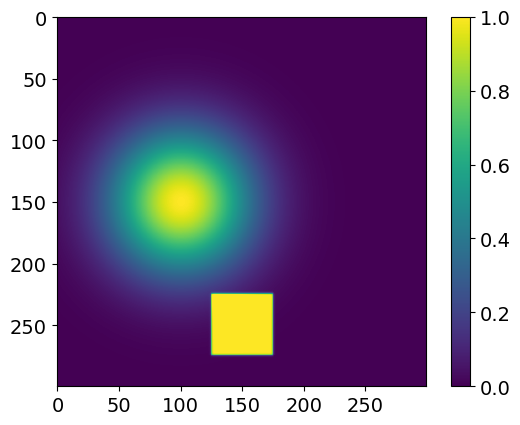

In [213]:
import numpy as np
# To plot pretty figures
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=14)
mpl.rc('ytick', labelsize=14)
import pandas as pd
from scipy.stats import multivariate_normal
from mpl_toolkits.mplot3d import Axes3D

def merge_2_subdomains(part1,part2):
    return np.concatenate([part1,part2],axis=1)


serial_0 = np.load('/Users/shuheng-mo/Desktop/simultas/examples/two_dimensions/serial_steps/AD_2D_step_0.npy').reshape(300,300)
serial_1 = np.load('/Users/shuheng-mo/Desktop/simultas/examples/two_dimensions/serial_steps/AD_2D_step_1.npy').reshape(300,300)

plt.imshow(serial_0,vmin=0,vmax=1)
plt.colorbar()

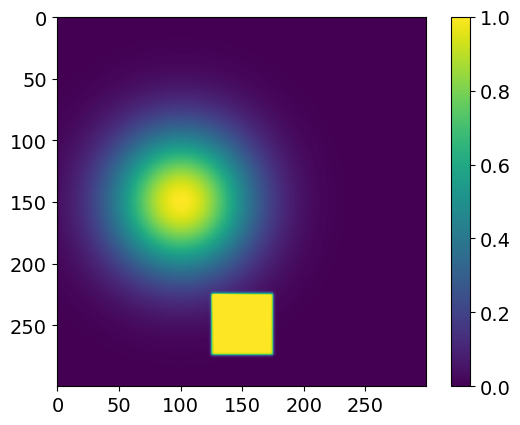

In [214]:
plt.imshow(serial_1,vmin=0,vmax=1)
plt.colorbar()

0.0

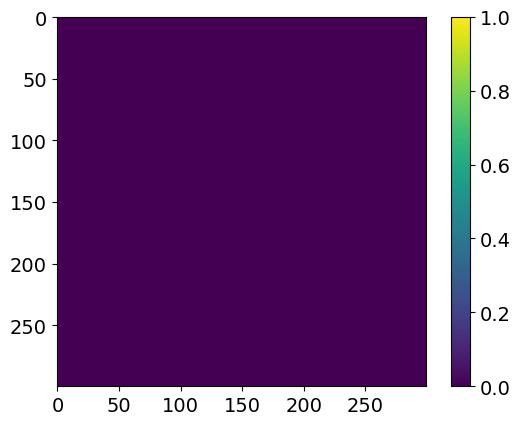

In [215]:
p_0_0 = np.load('/Users/shuheng-mo/Desktop/simultas/examples/two_dimensions/parallel_steps/AD_2D_proc_0_parallel_2_step_0.npy').reshape(302,152)[1:-1,1:-1]
p_0_1 = np.load('/Users/shuheng-mo/Desktop/simultas/examples/two_dimensions/parallel_steps/AD_2D_proc_1_parallel_2_step_0.npy').reshape(302,152)[1:-1,1:-1]
# p_0_0 = np.load('/Users/shuheng-mo/Desktop/simultas/examples/two_dimensions/parallel_steps/AD_2D_proc_0_parallel_2_step_0.npy').reshape(302,152)
# p_0_1 = np.load('/Users/shuheng-mo/Desktop/simultas/examples/two_dimensions/parallel_steps/AD_2D_proc_1_parallel_2_step_0.npy').reshape(302,152)
parallel_0 = np.concatenate([p_0_0,p_0_1],axis=1)
plt.imshow(np.abs(parallel_0 - serial_0),vmin=0,vmax=1)
# plt.imshow(parallel_0,vmin=0,vmax=1)
plt.colorbar()
np.sum(np.abs(parallel_0 - serial_0)) # completely same for 1st loop

0.019581067200045765

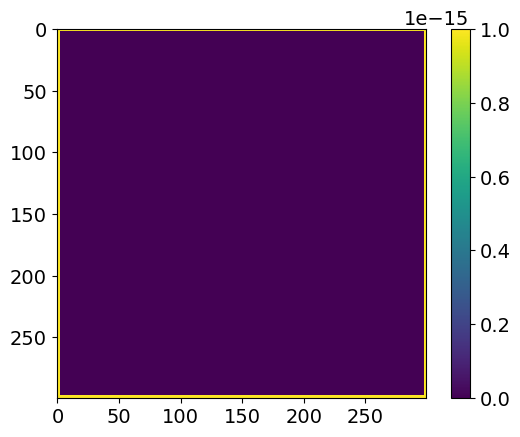

In [216]:
p_1_0 = np.load('/Users/shuheng-mo/Desktop/simultas/examples/two_dimensions/parallel_steps/AD_2D_proc_0_parallel_2_step_1.npy').reshape(302,152)[1:-1,1:-1]
p_1_1 = np.load('/Users/shuheng-mo/Desktop/simultas/examples/two_dimensions/parallel_steps/AD_2D_proc_1_parallel_2_step_1.npy').reshape(302,152)[1:-1,1:-1]
parallel_1 = np.concatenate([p_1_0,p_1_1],axis=1)
plt.imshow(np.abs(parallel_1 - serial_1),vmin=0,vmax=1e-15)
plt.colorbar()
np.sum(np.abs(parallel_1 - serial_1)) # this is not correct

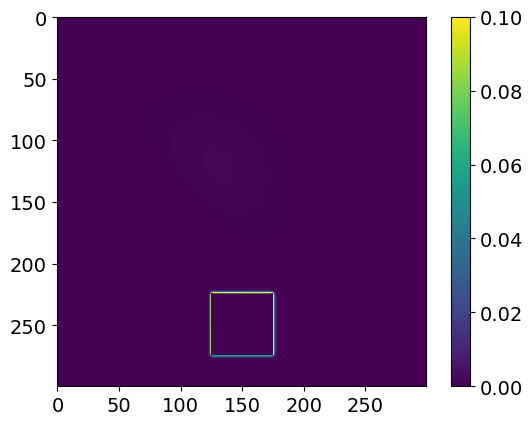

In [217]:
a_1 = np.load('/Users/shuheng-mo/Desktop/simultas/examples/two_dimensions/serial_steps/a_1.npy').reshape(300,300)

plt.imshow(a_1,vmin=0,vmax=0.1)
plt.colorbar()

0.013936132


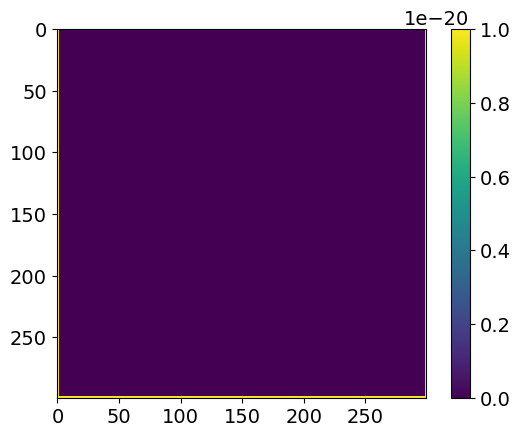

In [226]:
a_p_0_0 = np.load('/Users/shuheng-mo/Desktop/simultas/examples/two_dimensions/parallel_steps/a_proc_0_step_1.npy').reshape(302,152)[1:-1,1:-1]
a_p_0_1 = np.load('/Users/shuheng-mo/Desktop/simultas/examples/two_dimensions/parallel_steps/a_proc_1_step_1.npy').reshape(302,152)[1:-1,1:-1]

a_p_0 = merge_2_subdomains(a_p_0_0,a_p_0_1)

plt.imshow(np.abs(a_p_0 - a_1),vmin=0,vmax=1e-20)
# plt.imshow(a_p_0 ,vmin=0,vmax=0.1)
plt.colorbar()

print(np.sum(np.abs(a_p_0 - a_1)))
# 0.013936132

In [237]:
## imports
import sys
assert sys.version_info >= (3,5)

import math

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os
import time
from mpi4py import MPI

w1 = ([[[[0.0],        # upwind
        [0.2],
        [0.0]],

        [[0.3],
        [-1.0],
        [0.2]],

        [[0.0],
        [0.3],
        [0.0]]]])

w2 = ([[[[0.0],        # central
        [0.15],
        [0.0]],

        [[0.25],
        [-0.8],
        [0.15]],

        [[0.0],
        [0.25],
        [0.0]]]])


init_kernel_1 = w1
init_kernel_2 = w2

init_bias = np.zeros((1,))  # filters - need change to exact value for bias

kernel_initializer_1 = tf.keras.initializers.constant(
    init_kernel_1)  # initializer which initialize constant tensor
kernel_initializer_2 = tf.keras.initializers.constant(init_kernel_2)

bias_initializer = tf.keras.initializers.constant(init_bias)

# CNN 2D layers: now I generate CNN filters for each subdomains
# filter 1
CNN2D_1 = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=(300, 300, 1)),
    tf.keras.layers.Conv2D(1, kernel_size=3, strides=1, padding='SAME',
                          kernel_initializer=kernel_initializer_1,
                          bias_initializer=bias_initializer),
])

# filter 2
CNN2D_2 = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=(300, 300, 1)),
    tf.keras.layers.Conv2D(1, kernel_size=3, strides=1, padding='SAME',
                          kernel_initializer=kernel_initializer_2,
                          bias_initializer=bias_initializer),
])

# test case
CNN2D_3 = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=(302, 152, 1)),
    tf.keras.layers.Conv2D(1, kernel_size=3, strides=1, padding='SAME',
                          kernel_initializer=kernel_initializer_2,
                          bias_initializer=bias_initializer),
])

# here set up the hyperparameters to tune in the later training process
CNN2D_1.compile(loss="mse",
                optimizer=keras.optimizers.Nadam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999))
CNN2D_2.compile(loss="mse",
                optimizer=keras.optimizers.Nadam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999))
CNN2D_3.compile(loss="mse",
                optimizer=keras.optimizers.Nadam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999))

p_0_0 = np.load('/Users/shuheng-mo/Desktop/simultas/examples/two_dimensions/parallel_steps/AD_2D_proc_0_parallel_2_step_0.npy')
p_0_1 = np.load('/Users/shuheng-mo/Desktop/simultas/examples/two_dimensions/parallel_steps/AD_2D_proc_1_parallel_2_step_0.npy')

serial_a_1 = CNN2D_2.predict(serial_0.reshape(1,300,300,1)).reshape(300,300)
parallel_a_1 = CNN2D_2.predict(parallel_0.reshape(1,300,300,1)).reshape(300,300)

p_test_a01 = CNN2D_3.predict(p_0_0).reshape(302,152)
p_test_a11 = CNN2D_3.predict(p_0_1).reshape(302,152)
p_test_a1 = merge_2_subdomains(p_test_a01[1:-1,1:-1],p_test_a11[1:-1,1:-1])


1/1 [==============================] - 0s 24ms/step


In [238]:
np.sum(np.abs(serial_a_1 - parallel_a_1)) # it ought to be the same

0.0

In [240]:
np.sum(np.abs(serial_a_1 - p_test_a1)) # double check the 

0.013936132

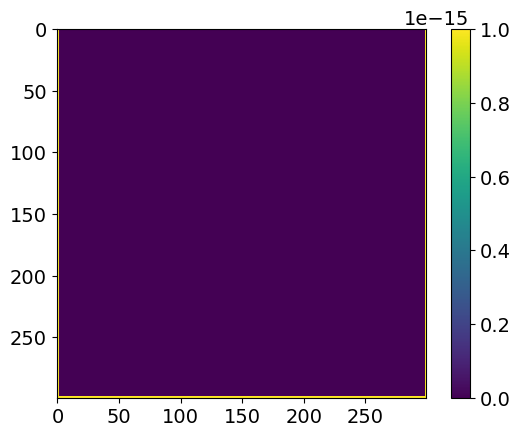

In [249]:
from pprint import pprint
np.savetxt('truth.txt',serial_a_1)
np.savetxt('testcase.txt',p_test_a1)
plt.imshow(np.abs(serial_a_1 - p_test_a1),vmin=0,vmax=1e-15)
plt.colorbar()

(300, 300)


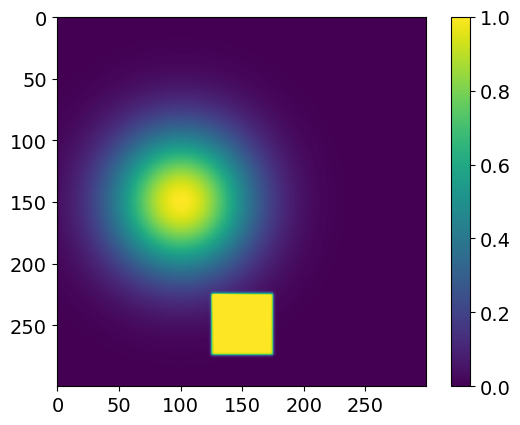

In [168]:
## Visualization and compare the final result of serial/parallel codes
import numpy as np
# To plot pretty figures
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=14)
mpl.rc('ytick', labelsize=14)
import pandas as pd
from scipy.stats import multivariate_normal
from mpl_toolkits.mplot3d import Axes3D

## visualize the serial output
serial_solution = np.load("output/AD_2D_serial.npy")
print(serial_solution.shape)
plt.imshow(serial_solution,vmin=0,vmax=1)
plt.colorbar()

(300, 300)


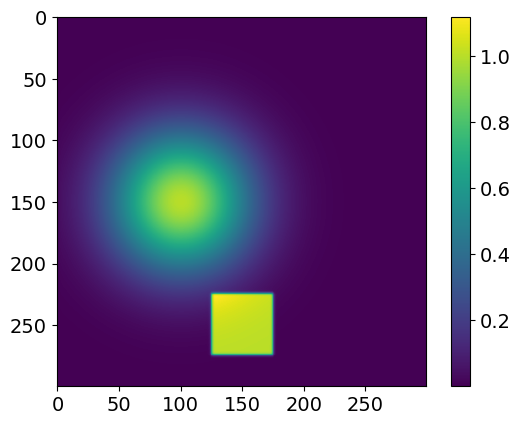

In [78]:
import numpy as np
import matplotlib.pyplot as plt

subdomains_list = []
num_process = 2
for p_id in range(0,2):
  temp = np.load("output/AD_2D_proc_{}_parallel_{}.npy".format(p_id,num_process))
  subdomains_list.append(temp)
  
# get merged result and then visualize it

# two subdomains ...
parallel_solution = np.concatenate([subdomains_list[0], subdomains_list[1]],axis = 1)
print(parallel_solution.shape)
plt.imshow(parallel_solution)
plt.colorbar()

# four subdomains ...
# parallel_solution_1 = np.concatenate([subdomains_list[0],subdomains_list[1]],axis=1) # this time we only need to combine horizontally
# parallel_solution_2 = np.concatenate([subdomains_list[2],subdomains_list[3]],axis=1) # this time we only need to combine horizontally
# parallel_solution = np.concatenate([parallel_solution_1,parallel_solution_2],axis=0)
# print(parallel_solution.shape)
# plt.imshow(parallel_solution)
# plt.colorbar()

# nine domains 
# parallel_solution_1 = np.concatenate([subdomains_list[0],subdomains_list[1],subdomains_list[2]],axis=1) # this time we only need to combine horizontally
# parallel_solution_2 = np.concatenate([subdomains_list[3],subdomains_list[4],subdomains_list[5]],axis=1) # this time we only need to combine horizontally
# parallel_solution_3 = np.concatenate([subdomains_list[6],subdomains_list[7],subdomains_list[8]],axis=1) # this time we only need to combine horizontally
# parallel_solution = np.concatenate([parallel_solution_1,parallel_solution_2,parallel_solution_3],axis=0)
# print(parallel_solution.shape)
# plt.imshow(parallel_solution)
# plt.colorbar()

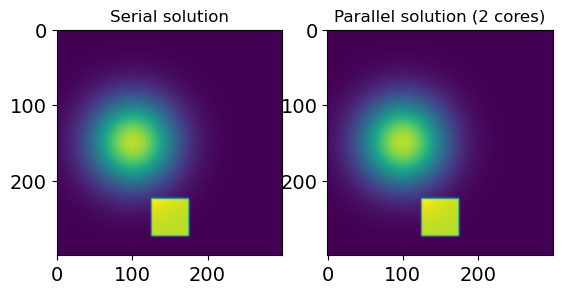

abe: 0.019581067200045765
avg abe: 2.1756741333384183e-07
norm abe: 1.467162817903045e-06
avg norm abe: 1.6301809087811612e-11


In [79]:
# compare the visualization 
fig, axes = plt.subplots(1, 2)
axes[0].imshow(serial_solution)
axes[0].title.set_text('Serial solution')
axes[1].imshow(parallel_solution)
axes[1].title.set_text('Parallel solution (2 cores)')

plt.savefig("result_validation.png")
plt.show()
# all error should be zero
print('abe:',np.sum(np.abs(serial_solution - parallel_solution)))
print('avg abe:',np.sum(np.abs(serial_solution - parallel_solution))/(300*300))
print('norm abe:',np.abs(np.linalg.norm(serial_solution) - np.linalg.norm(parallel_solution)))
print('avg norm abe:',np.abs(np.linalg.norm(serial_solution) - np.linalg.norm(parallel_solution))/(300*300))

## Study of the differences between L1/L2 Norms of the serial and parallel implementation 
Ensure the accuracy error is small enough (indentical). So the parallelisation is valid.

In [ ]:
serial_l1_norms = np.load("/content/norms/AD_2D_serial_l1_norms.npy")
serial_l2_norms = np.load("/content/norms/AD_2D_serial_l2_norms.npy")
serial_linf_norms = np.load("/content/norms/AD_2D_serial_linf_norms.npy")

FileNotFoundError: ignored

In [ ]:
# compute the L1/L2 norms of the parallel implementation
parallel_l1_norms = np.array([])
parallel_l2_norms = np.array([])
parallel_linf_norms = np.array([])
parallel_steps = []

for t in range(1000):
  # 2 sub_domains
  region_1 = np.load("/content/parallel_steps/AD_2D_proc_0_parallel_2_step_{}.npy".format(t))[0,1:-1,1:-1,0]
  region_2 = np.load("/content/parallel_steps/AD_2D_proc_1_parallel_2_step_{}.npy".format(t))[0,1:-1,1:-1,0]

  # 9 sub_domains ...
  # region_1 = np.load("/content/parallel_steps/AD_2D_proc_0_parallel_9_step_{}.npy".format(t))
  # region_2 = np.load("/content/parallel_steps/AD_2D_proc_1_parallel_9_step_{}.npy".format(t))
  # region_3 = np.load("/content/parallel_steps/AD_2D_proc_2_parallel_9_step_{}.npy".format(t))
  # region_4 = np.load("/content/parallel_steps/AD_2D_proc_3_parallel_9_step_{}.npy".format(t))
  # region_5 = np.load("/content/parallel_steps/AD_2D_proc_4_parallel_9_step_{}.npy".format(t))
  # region_6 = np.load("/content/parallel_steps/AD_2D_proc_5_parallel_9_step_{}.npy".format(t))
  # region_7 = np.load("/content/parallel_steps/AD_2D_proc_6_parallel_9_step_{}.npy".format(t))
  # region_8 = np.load("/content/parallel_steps/AD_2D_proc_7_parallel_9_step_{}.npy".format(t))
  # region_9 = np.load("/content/parallel_steps/AD_2D_proc_8_parallel_9_step_{}.npy".format(t))

  # 16 sub_domains ...
  # region_1 = np.load("/content/parallel_steps/AD_2D_proc_0_parallel_16_step_{}.npy".format(t))
  # region_2 = np.load("/content/parallel_steps/AD_2D_proc_1_parallel_16_step_{}.npy".format(t))
  # region_3 = np.load("/content/parallel_steps/AD_2D_proc_2_parallel_16_step_{}.npy".format(t))
  # region_4 = np.load("/content/parallel_steps/AD_2D_proc_3_parallel_16_step_{}.npy".format(t))
  # region_5 = np.load("/content/parallel_steps/AD_2D_proc_4_parallel_16_step_{}.npy".format(t))
  # region_6 = np.load("/content/parallel_steps/AD_2D_proc_5_parallel_16_step_{}.npy".format(t))
  # region_7 = np.load("/content/parallel_steps/AD_2D_proc_6_parallel_16_step_{}.npy".format(t))
  # region_8 = np.load("/content/parallel_steps/AD_2D_proc_7_parallel_16_step_{}.npy".format(t))
  # region_9 = np.load("/content/parallel_steps/AD_2D_proc_8_parallel_16_step_{}.npy".format(t))
  # region_10 = np.load("/content/parallel_steps/AD_2D_proc_9_parallel_16_step_{}.npy".format(t))
  # region_11 = np.load("/content/parallel_steps/AD_2D_proc_10_parallel_16_step_{}.npy".format(t))
  # region_12 = np.load("/content/parallel_steps/AD_2D_proc_11_parallel_16_step_{}.npy".format(t))
  # region_13 = np.load("/content/parallel_steps/AD_2D_proc_12_parallel_16_step_{}.npy".format(t))
  # region_14 = np.load("/content/parallel_steps/AD_2D_proc_13_parallel_16_step_{}.npy".format(t))
  # region_15 = np.load("/content/parallel_steps/AD_2D_proc_14_parallel_16_step_{}.npy".format(t))
  # region_16 = np.load("/content/parallel_steps/AD_2D_proc_15_parallel_16_step_{}.npy".format(t))
   
  # 2 subdomains
  region = np.concatenate([region_1, region_2],axis = 1)
  parallel_steps.append(region)

  # print(region.shape)
  # 9 
  # region_row_1 = np.concatenate([region_1, region_2,region_3],axis = 1)
  # region_row_2 = np.concatenate([region_4, region_5,region_6],axis = 1)
  # region_row_3 = np.concatenate([region_7, region_8,region_9],axis = 1)
  # region = np.concatenate([region_row_1,region_row_2,region_row_3],axis = 0)
  # 16
  # region_row_1 = np.concatenate([region_1, region_2,region_3,region_4],axis = 1)
  # region_row_2 = np.concatenate([region_5,region_6,region_7,region_8],axis = 1)
  # region_row_3 = np.concatenate([region_9, region_10,region_11,region_12],axis = 1)
  # region_row_4 = np.concatenate([region_13, region_14,region_15, region_16],axis = 1)
  # region = np.concatenate([region_row_1,region_row_2,region_row_3,region_row_4],axis = 0)

  parallel_l1_norms = np.append(parallel_l1_norms, np.linalg.norm(region, ord=1)/90000)
  parallel_l2_norms = np.append(parallel_l2_norms, np.linalg.norm(region, ord=2)/90000)
  parallel_linf_norms = np.append(parallel_linf_norms, np.linalg.norm(region, ord=np.inf)/90000)

In [ ]:
# plt.title("L1 norm of serial implementation") 

# plt.plot(serial_l1_norms) 
# plt.xlabel("Time steps")
# plt.ylabel("L1-Norm")
# plt.grid()
# plt.show() 

In [ ]:
# plt.title("L1 norm of parallel implementation")

# plt.plot(parallel_l1_norms) 
# plt.xlabel("Time steps")
# plt.ylabel("L1-Norm")
# plt.grid()
# plt.show() 

In [ ]:
# plt.title("ABE of L1-Norm between serial and parallel")

abe_l1 = np.abs(serial_l1_norms - parallel_l1_norms)

# # print(abe_l1)

# plt.plot(abe_l1) 
# plt.xlabel("Time steps")
# plt.ylabel("ABE-L1-NORM")
# plt.grid()
# plt.show() 

In [ ]:
# plt.title("L2 norm of serial implementation") 

# plt.plot(serial_l2_norms) 
# plt.xlabel("Time steps")
# plt.ylabel("L2-Norm")
# plt.grid()
# plt.show()

In [ ]:
# plt.title("L2 norm of parallel implementation") 

# plt.plot(parallel_l2_norms) 
# plt.xlabel("Time steps")
# plt.ylabel("L2-Norm")
# plt.grid()
# plt.show()

In [ ]:
# plt.title("ABE of L2-Norm between serial and parallel")

abe_l2 = np.abs(serial_l2_norms - parallel_l2_norms)

# # print(abe_l2)

# plt.plot(abe_l1) 
# plt.xlabel("Time steps")
# plt.ylabel("ABE-L2-NORM")
# plt.grid()
# plt.show() 

In [ ]:
# plt.title("L-infinity norm of serial implementation") 

# plt.plot(serial_linf_norms) 
# plt.xlabel("Time steps")
# plt.ylabel("L-Infinity-Norm")
# plt.grid()
# plt.show()

In [ ]:
# plt.title("L-infinity norm of parallel implementation") 

# plt.plot(parallel_linf_norms) 
# plt.xlabel("Time steps")
# plt.ylabel("L-Infinity-Norm")
# plt.grid()
# plt.show()

In [ ]:
# plt.title("ABE of L-Infinity-Norm between serial and parallel")

abe_linf = np.abs(serial_linf_norms - parallel_linf_norms)

# # print(abe_l2)

# plt.plot(abe_linf) 
# plt.xlabel("Time steps")
# plt.ylabel("ABE-L-INF-NORM")
# plt.grid()
# plt.show()

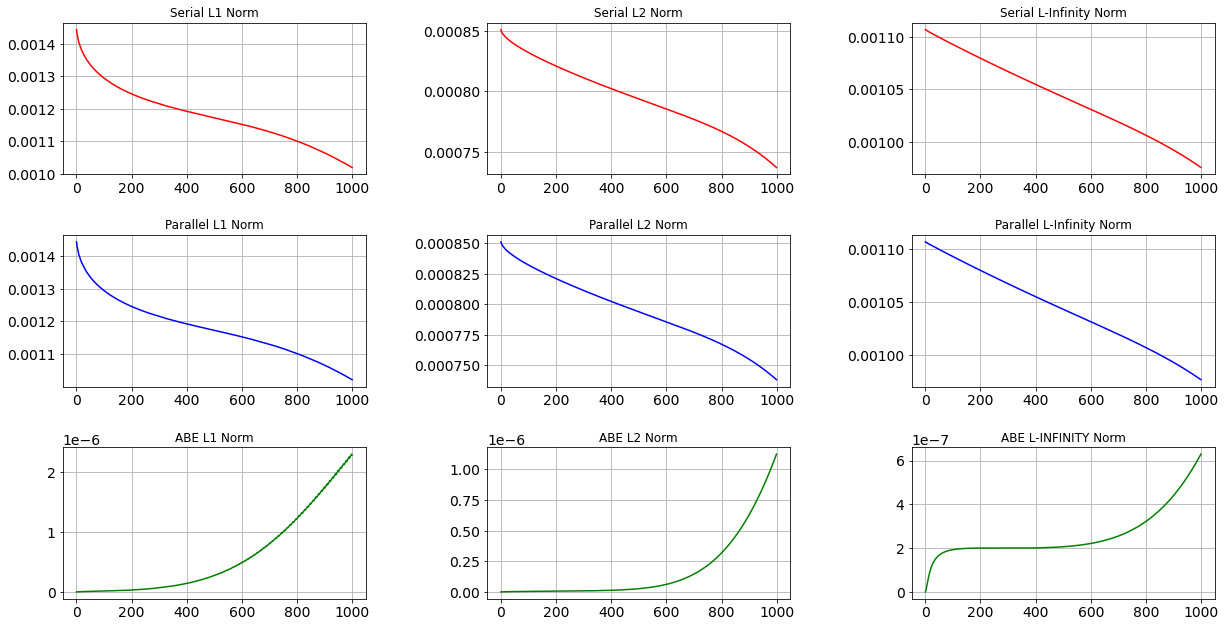

In [ ]:
fig, axes = plt.subplots(3, 3,figsize=(20, 10))

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

axes[0, 0].plot(serial_l1_norms,'r')
axes[0,0].title.set_text('Serial L1 Norm')
axes[0, 1].plot(serial_l2_norms,'r')
axes[0,1].title.set_text('Serial L2 Norm')
axes[0, 2].plot(serial_linf_norms,'r')
axes[0,2].title.set_text('Serial L-Infinity Norm')

axes[1, 0].plot(parallel_l1_norms, 'b')
axes[1,0].title.set_text('Parallel L1 Norm')
axes[1, 1].plot(parallel_l2_norms, 'b')
axes[1,1].title.set_text('Parallel L2 Norm')
axes[1, 2].plot(parallel_linf_norms, 'b')
axes[1,2].title.set_text('Parallel L-Infinity Norm')

axes[2, 0].plot(abe_l1, 'g')
axes[2,0].title.set_text('ABE L1 Norm')
axes[2, 1].plot(abe_l2, 'g')
axes[2,1].title.set_text('ABE L2 Norm')
axes[2, 2].plot(abe_linf, 'g')
axes[2,2].title.set_text('ABE L-INFINITY Norm')


axes[0,0].grid()
axes[0,1].grid()
axes[0,2].grid()
axes[1,0].grid()
axes[1,1].grid()
axes[1,2].grid()
axes[2,0].grid()
axes[2,1].grid()
axes[2,2].grid()

plt.savefig("accuracy_study.png")
plt.show()

## Spot the accuracy issue by comparing the spatial difference

In [ ]:
serial_steps = []
# parallel_steps = np.array([])

# load the spatial record of the serial code
for t in range(1000):
  region = np.load("/content/serial_steps/AD_2D_serial_step_{}.npy".format(t))
  serial_steps.append(region)

In [ ]:
spatial_diffs = []
for t in range(1000):
  spatial_diffs.append(abs(serial_steps[t] - parallel_steps[t]))

KeyboardInterrupt: ignored

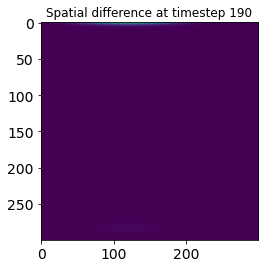

In [ ]:
! mkdir spatial_diffs

# made up to 500 time-steps
for t in range(500):
  plt.title('Spatial difference at timestep {}'.format(t))
  plt.imshow(spatial_diffs[t])
  plt.savefig('/content/spatial_diffs/spatial_diff_step_{}.png'.format(t))


In [ ]:
# generate the video
import cv2
import os

image_folder = '/content/spatial_diffs'
video_name = 'spatial_differences.mp4'

images = []

for i in range(500):
  img = cv2.imread('/content/spatial_diffs/spatial_diff_step_{}.png'.format(i))
  images.append(img) 

# images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
frame = images[0]
height, width, layers = frame.shape

fourcc = cv2.VideoWriter_fourcc(*'MP4V')
video = cv2.VideoWriter(video_name, fourcc, 1, (width,height))

for image in images:
    video.write(image)

cv2.destroyAllWindows()
video.release()

## Check accuracy error from the video

In [ ]:
from IPython.display import HTML
from base64 import b64encode

video_path = '/content/spatial_differences.mp4'
 
def show_video(video_path, video_width = 600):
   
  video_file = open(video_path, "r+b").read()
 
  video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
  return HTML(f"""<video width={video_width} controls><source src="{video_url}"></video>""")
 
show_video(video_path)